# Example: Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  MelbourneAirport     18.0     26.9      21.4          7.0       8.9   
1          Adelaide     17.2     23.4       0.0          NaN       NaN   
2            Cairns     18.6     24.6       7.4          3.0       6.1   
3          Portland     13.6     16.8       4.2          1.2       0.0   
4           Walpole     16.4     19.9       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           41.0          W        SSE  ...         95.0   
1           S           41.0          S        WSW  ...         59.0   
2         SSE           54.0        SSE         SE  ...         78.0   
3         ESE           39.0        ESE        ESE  ...         76.0   
4          SE           44.0         SE         SE  ...         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         54.0       1019.5       1017.0       8.0       5.0     18.5   
1         36.0       1015.7       1015.7       NaN       NaN     17.7   
2         57.0       1018.7       1016.6       3.0       3.0     20.8   
3         74.0       1021.4       1020.5       7.0       8.0     15.6   
4         70.0       1019.4       1018.9       NaN       NaN     17.4   

   Temp3pm  RainToday  RainTomorrow  
0     26.0        Yes             0  
1     21.9         No             0  
2     24.1        Yes             0  
3     16.0        Yes             1  
4     18.1         No             0  

[5 rows x 22 columns]

## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, rare_to_value=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9818
Test evaluation --> roc_auc: 0.8731
Time elapsed: 0.756s
-------------------------------------------------
Total time: 0.756s


Final results ==================== >>
Total time: 0.758s
-------------------------------------
LightGBM --> roc_auc: 0.8731


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Generating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Series([], dtype: int64)

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature MinTemp was removed due to collinearity with another feature.
 --> Feature MinTemp - WindDir9am was removed due to collinearity with another feature.
 --> Feature MaxTemp was removed due to collinearity with another feature.
 --> Feature MaxTemp + Temp3pm was removed due to collinearity with another feature.
 --> Feature Sunshine was removed due to collinearity with another feature.
 --> Feature Sunshine - WindDir9am was removed due to collinearity with another feature.
 --> Feature Location + WindGustSpeed was removed due to collinearity with another feature.
 --> Feature RainToday_No + WindGustSpeed was removed due to collinearity with another feature.
 --> Feature WindSpeed9am was removed due to collinearity with another feature.
 --> Feature WindSpeed3pm was removed due to collinearity with another feature.
 --> Feature WindDir9am + WindSpeed3pm was removed due to collinearity with another feature.
 --> Featur

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

drop  \
0                        MinTemp   
1           MinTemp - WindDir9am   
2                        MaxTemp   
3              MaxTemp + Temp3pm   
4                       Sunshine   
5          Sunshine - WindDir9am   
6       Location + WindGustSpeed   
7   RainToday_No + WindGustSpeed   
8                   WindSpeed9am   
9                   WindSpeed3pm   
10     WindDir9am + WindSpeed3pm   
11                   Humidity9am   
12                   Humidity3pm   
13   Humidity3pm - RainToday_Yes   
14                   Pressure9am   
15  Pressure9am + RainToday_rare   
16      Pressure9am + WindDir3pm   
17     Pressure9am - WindGustDir   
18                      Cloud9am   
19         Cloud9am - WindDir3pm   
20         Cloud9am - WindDir9am   
21                      Cloud3pm   
22                       Temp9am   
23                       Temp3pm   
24     RainToday_No - WindDir9am   
25   RainToday_Yes - WindGustDir   
26                RainToday_rare   
27     Evaporation - Humidity3pm   
28           Location - Sunshine   

                                         corr_feature  \
0        MinTemp - RainToday_No, MinTemp - WindDir9am   
1                     MinTemp, MinTemp - RainToday_No   
2             MaxTemp + Temp3pm, MaxTemp + WindDir3pm   
3              MaxTemp, Temp3pm, MaxTemp + WindDir3pm   
4        Sunshine + WindDir9am, Sunshine - WindDir9am   
5                     Sunshine, Sunshine + WindDir9am   
6         WindGustSpeed, RainToday_No + WindGustSpeed   
7             WindGustSpeed, Location + WindGustSpeed   
8                           WindDir9am + WindSpeed9am   
9   RainToday_Yes + WindSpeed3pm, WindDir9am + Win...   
10         WindSpeed3pm, RainToday_Yes + WindSpeed3pm   
11                             Humidity9am - Sunshine   
12  Humidity3pm + WindGustDir, Humidity3pm - RainT...   
13             Humidity3pm, Humidity3pm + WindGustDir   
14  Pressure9am + RainToday_Yes, Pressure9am + Rai...   
15  Pressure9am, Pressure9am + RainToday_Yes, Pres...   
16  Pressure9am, Pressure9am + RainToday_Yes, Pres...   
17  Pressure9am, Pressure9am + RainToday_Yes, Pres...   
18  Cloud9am + WindDir9am, Cloud9am - WindDir3pm, ...   
19  Cloud9am, Cloud9am + WindDir9am, Cloud9am - Wi...   
20  Cloud9am, Cloud9am + WindDir9am, Cloud9am - Wi...   
21                           Cloud3pm + RainToday_Yes   
22                               Temp9am + WindDir9am   
23                                  MaxTemp + Temp3pm   
24                                       RainToday_No   
25                                      RainToday_Yes   
26                          Location + RainToday_rare   
27                             Cloud3pm - Humidity3pm   
28                          RainToday_rare - Sunshine   

                        corr_value  
0                      0.9979, 1.0  
1                      1.0, 0.9978  
2                      0.9926, 1.0  
3           0.9926, 0.9921, 0.9926  
4                   0.9998, 0.9998  
5                   0.9998, 0.9994  
6                      1.0, 0.9995  
7                   0.9995, 0.9995  
8                              1.0  
9                      0.9989, 1.0  
10                     1.0, 0.9989  
11                          0.9919  
12                     1.0, 0.9998  
13                  0.9998, 0.9998  
14        0.9982, 0.9999, 1.0, 1.0  
15  0.9999, 0.9981, 0.9999, 0.9999  
16     1.0, 0.9982, 0.9999, 0.9999  
17     1.0, 0.9982, 0.9999, 0.9999  
18          0.9998, 0.9998, 0.9998  
19          0.9998, 0.9995, 0.9997  
20          0.9998, 0.9991, 0.9997  
21                          0.9837  
22                             1.0  
23                          0.9921  
24                          0.9932  
25                          0.9946  
26                             1.0  
27                          0.9848  
28                          0.9993

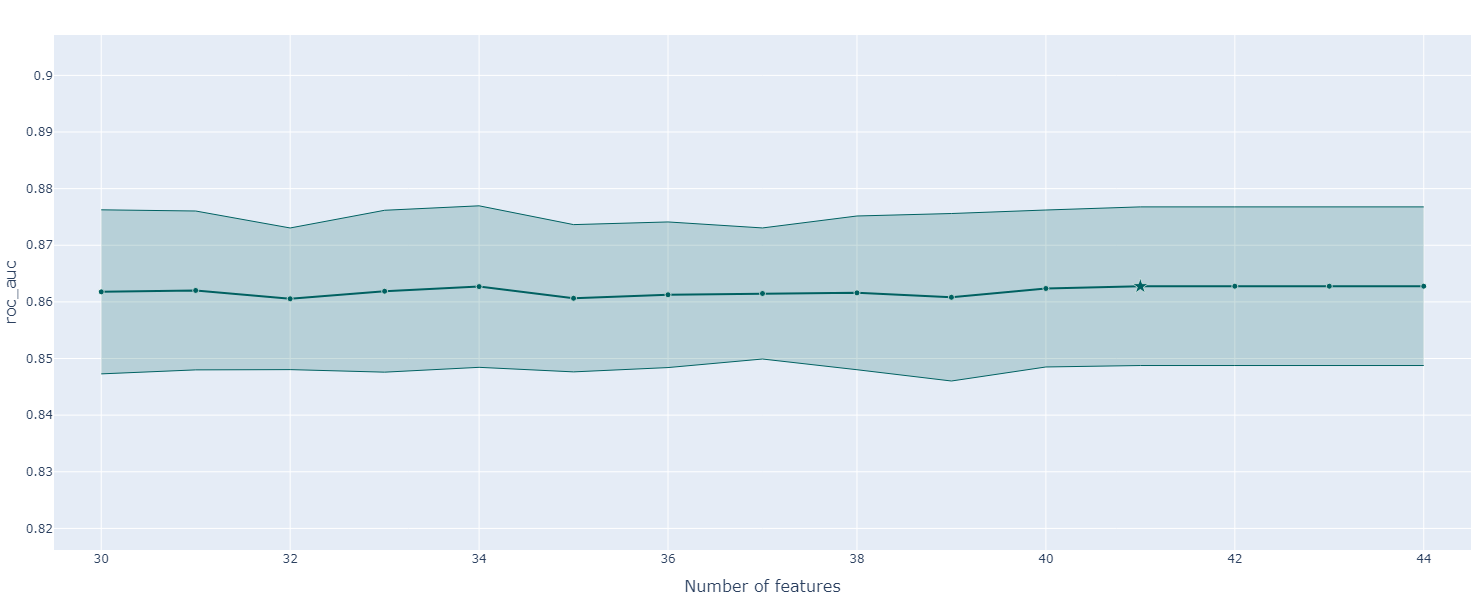

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9892
Test evaluation --> roc_auc: 0.8695
Time elapsed: 1.366s
-------------------------------------------------
Total time: 1.366s


Final results ==================== >>
Total time: 1.369s
-------------------------------------
LightGBM --> roc_auc: 0.8695


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.04         0.133462        3         0.493363              N/A     24.70s
   1     3.12         0.335129        6         0.494172              N/A     26.16s
   2     3.51           0.4185        7         0.506896              N/A     23.77s
   3     3.76         0.445187        7         0.516331              N/A     21.20s
   4     5.68         0.457463       12         0.527325              N/A     20.40s
   5     7.35         0.461538       10         0.530084              N/A     19.38s
   6     9.04         0.465166       14         0.533725              N/A     16.00s
   7     9.57         0.467906       14         0.538791              N/A     12.52s
   8    10.50         0.475384       16        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

name                                        description   fitness
0   x23  sub(Pressure3pm, sub(sub(add(WindGustSpeed, su...  0.530064
1   x24  sub(Pressure3pm, sub(sub(add(WindGustSpeed, su...  0.530064
2   x25  sub(sub(sub(add(WindGustSpeed, sub(add(Humidit...  0.530064
3   x26  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.530064
4   x27  sub(Pressure3pm, sub(add(WindGustSpeed, sub(su...  0.530064
5   x28  sub(Pressure3pm, sub(sub(add(sub(add(Humidity3...  0.530064
6   x29  sub(Pressure3pm, sub(sub(add(sub(add(Humidity3...  0.530064
7   x30  sub(sub(add(WindGustSpeed, sub(sub(add(Humidit...  0.530064
8   x31  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.530064
9   x32  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.529064
10  x33  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.528712
11  x34  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.528712
12  x35  sub(Pressure3pm, sub(sub(add(WindGustSpeed, su...  0.528712
13  x36  sub(Pressure3pm, sub(sub(add(WindGustSpeed, su...  0.528712
14  x37  sub(sub(sub(add(WindGustSpeed, sub(sub(add(Hum...  0.528712
15  x38  sub(Pressure3pm, sub(add(WindGustSpeed, sub(su...  0.528712
16  x39  sub(sub(sub(sub(add(WindGustSpeed, sub(add(Hum...  0.528712
17  x40  sub(Pressure3pm, sub(sub(sub(sub(add(WindGustS...  0.528712
18  x41  sub(Pressure3pm, sub(sub(sub(sub(add(WindGustS...  0.528712
19  x42  sub(Pressure3pm, sub(sub(sub(add(WindGustSpeed...  0.528712

In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9836
Test evaluation --> roc_auc: 0.8767
Time elapsed: 1.003s
-------------------------------------------------
Total time: 1.003s


Final results ==================== >>
Total time: 1.005s
-------------------------------------
LightGBM --> roc_auc: 0.8767


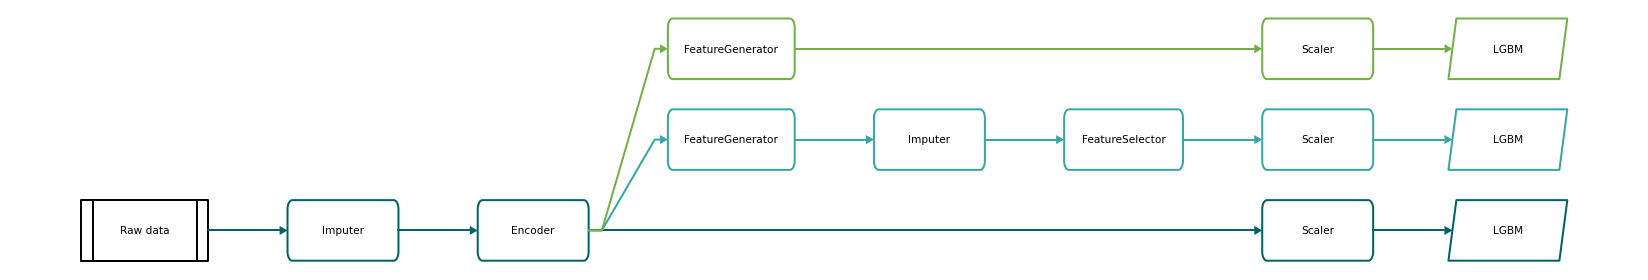

In [17]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze the results

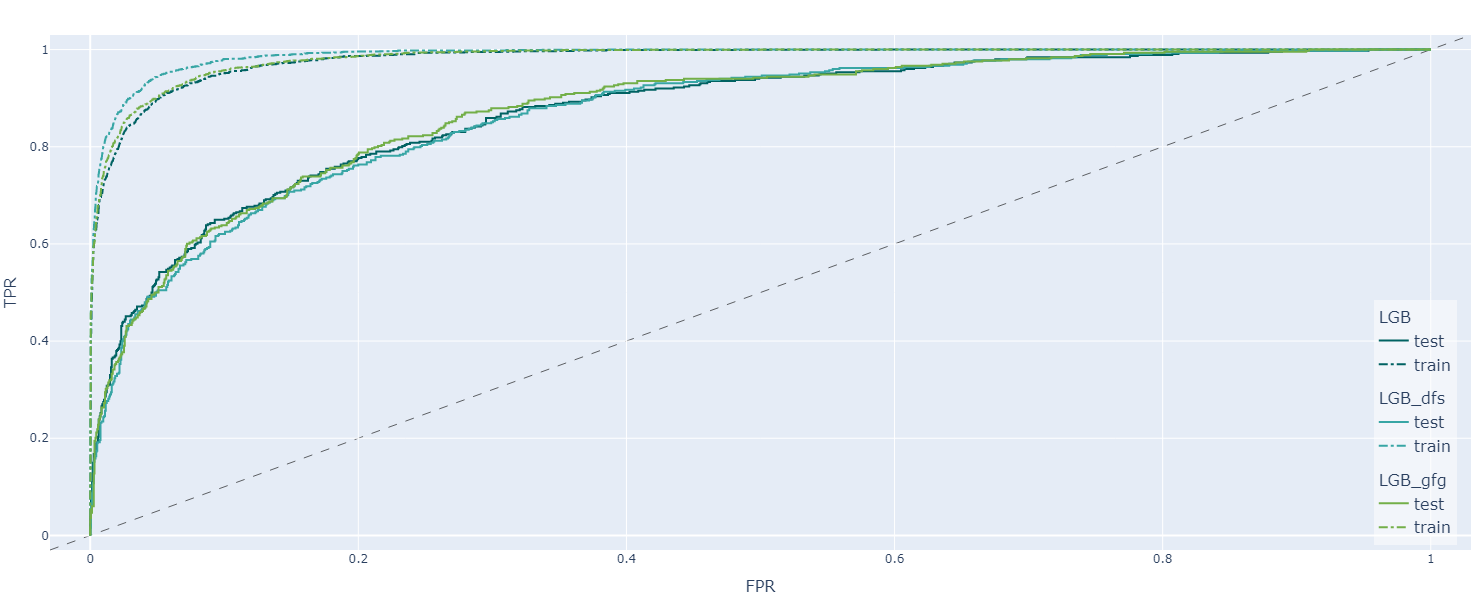

In [18]:
# Use atom's plots to compare the three models
atom.plot_roc(dataset="test+train")

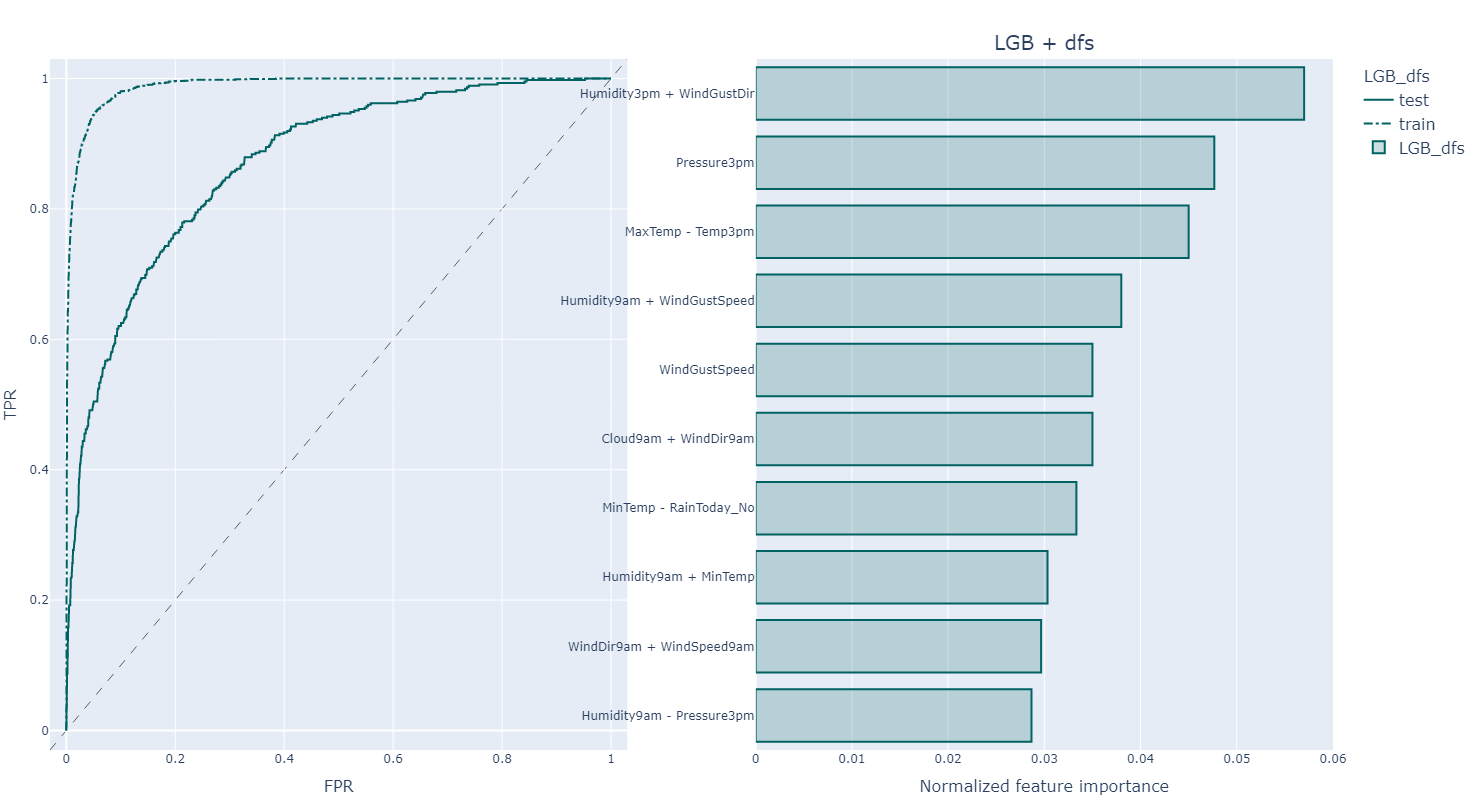

In [19]:
# To compare other plots it might be useful to use a canvas
with atom.canvas(1, 2, figsize=(1800, 800)):
    atom.lgb_dfs.plot_roc(dataset="test+train")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")

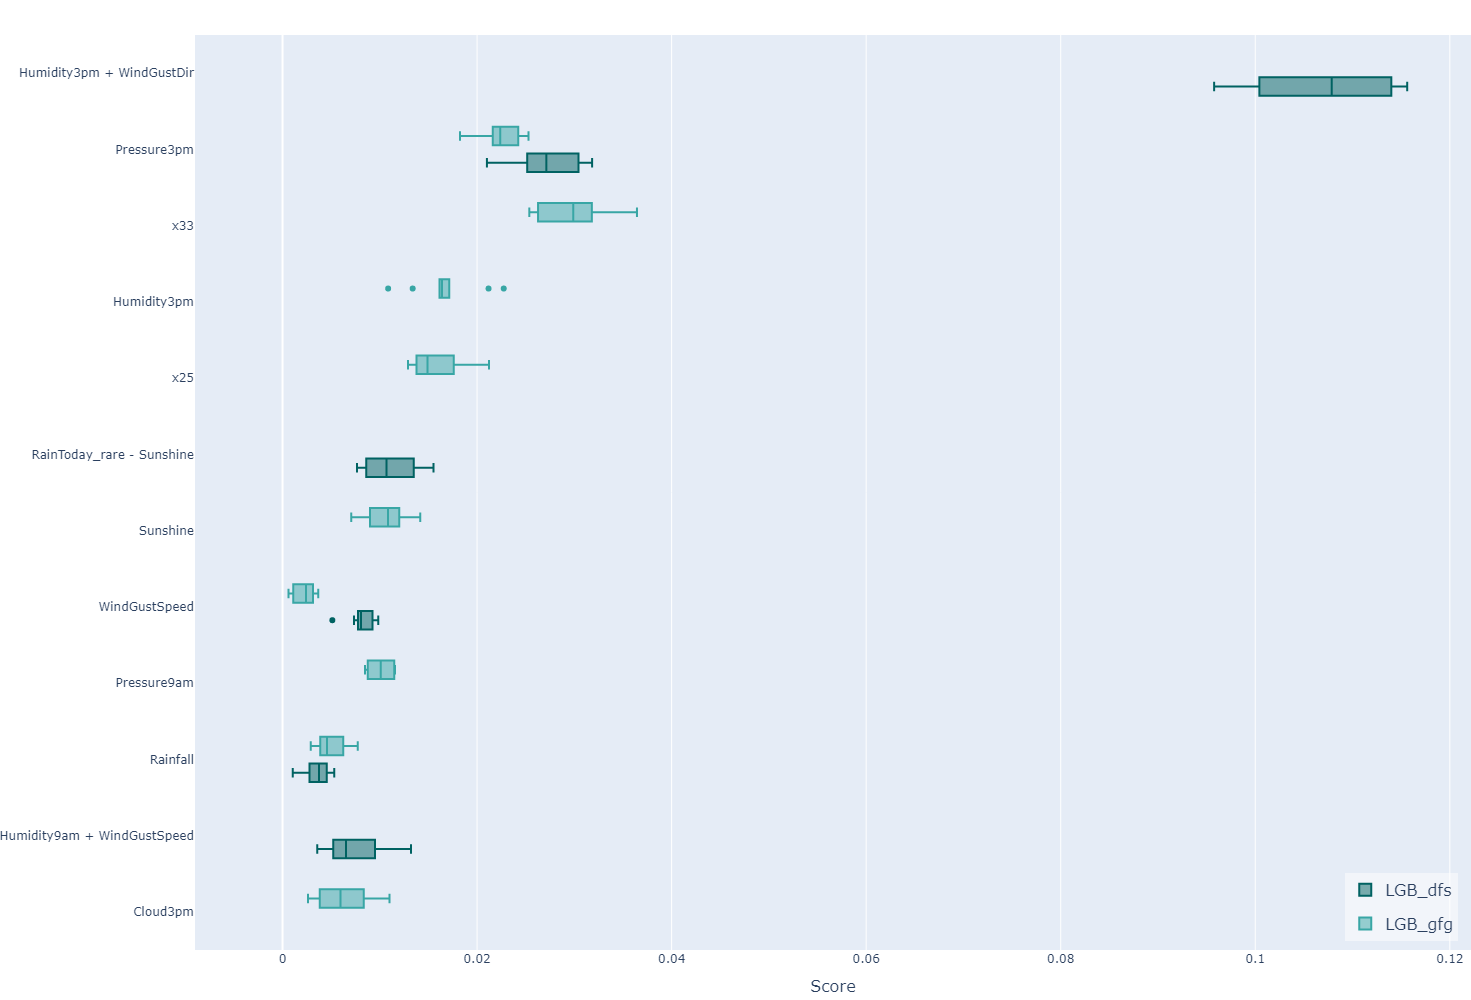

In [20]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=12)

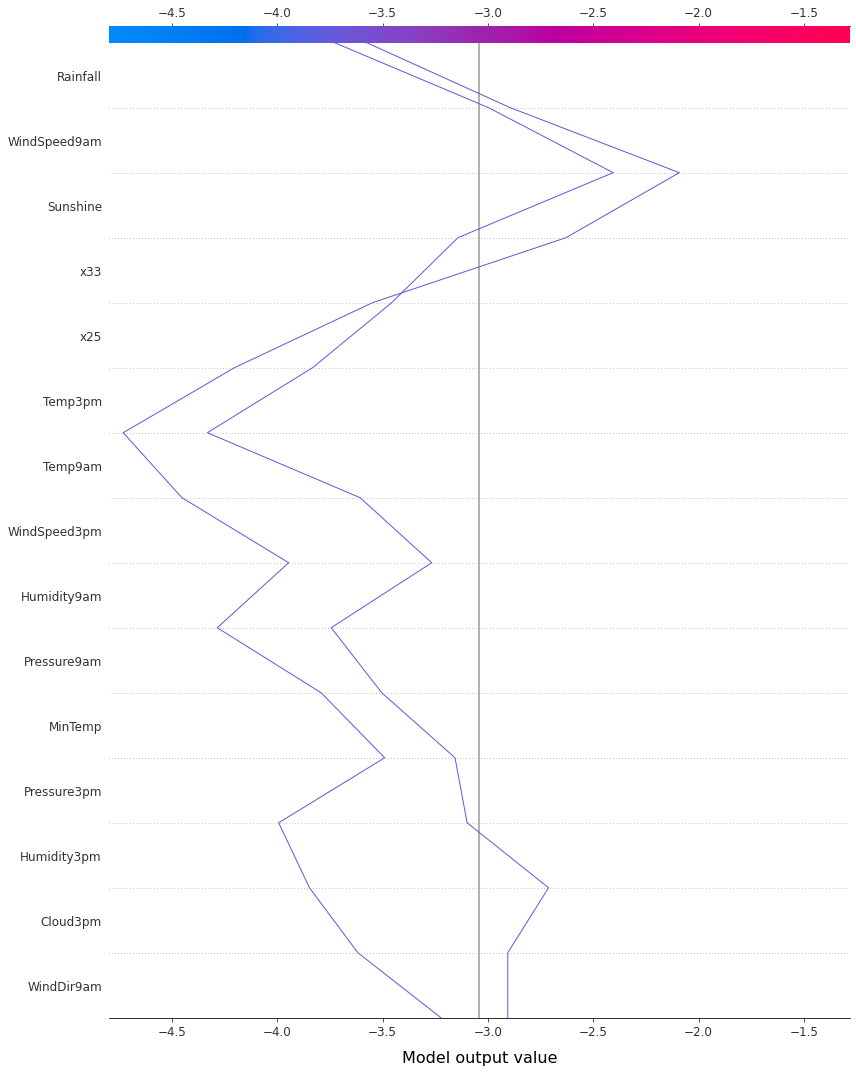

In [21]:
atom.LGB_gfg.plot_shap_decision(index=(0, 10), show=15)